In [1]:
# @@@@@@@@@@@@@@@@@@@       DATA PREPROCESSING      @@@@@@@@@@@@@@@@@@@
# @@@@@@@@@@@@@@@@@@@       SPLITTING      @@@@@@@@@@@@@@@@@@@
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.conftest import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import re
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
import sys, os

# # # # https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
# # # if not sys.warnoptions:
# # #     warnings.simplefilter("ignore")
# # #     os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses


categories = ["rec.motorcycles", "rec.autos", "rec.sport.baseball"]

twenty_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42
)

twenty_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42
)


# Extract the "Organization" and "Subject" lines completely from the "text" feature
def extract_information(text):
    lines = text.split("\n")
    organization_line = next(
        (line for line in lines if line.startswith("Organization:")), ""
    )
    subject_line = next((line for line in lines if line.startswith("Subject:")), "")

    organization_removed_text = text.replace(organization_line, "")
    subject_removed_text = organization_removed_text.replace(subject_line, "")

    organization = organization_line.replace("Organization:", "").strip()
    subject = subject_line.replace("Subject:", "").strip()

    return organization, subject, subject_removed_text


# Extract information from the "text" feature for the training and test datasets
organization_train = []
subject_train = []
text_without_information_train = []
for text in twenty_train.data:
    organization, subject, text_without_information = extract_information(text)
    organization_train.append(organization)
    subject_train.append(subject)
    text_without_information_train.append(text_without_information)

organization_test = []
subject_test = []
text_without_information_test = []
for text in twenty_test.data:
    organization, subject, text_without_information = extract_information(text)
    organization_test.append(organization)
    subject_test.append(subject)
    text_without_information_test.append(text_without_information)

# Map target labels to target names
target_names = twenty_train.target_names

target_labels_train = twenty_train.target
target_text_train = [target_names[label] for label in target_labels_train]

target_labels_test = twenty_test.target
target_text_test = [target_names[label] for label in target_labels_test]

# Create a DataFrame for the combined dataset
df_combined = pd.DataFrame(
    {
        "target": target_text_train + target_text_test,
        "text": text_without_information_train + text_without_information_test,
        "organization": organization_train + organization_test,
        "subject": subject_train + subject_test,
    }
)


def showDatasetCharacteristics(df_combined, tittle):
    print(tittle, " \n")

    print(
        "Dataset columns: \n",
        "\t",
        df_combined.columns,
        "\n",
    )
    # Display the initial dimensions of the dataset
    print(
        "Dataset dimensions (rows, columns) : \n",
        "\t",
        df_combined.shape,
        "\n",
    )

    # Retrieve the unique classes in the "Difficulty_Level" column
    unique_classes = df_combined["target"].unique()
    print(
        "Unique classes: \n",
        "\t",
        unique_classes,
        "\n",
    )


showDatasetCharacteristics(df_combined, "-----> Before text cleaning")


def removeRowsWithMissingValues(df_combined):
    collumns = [
        "target",
        "text",
        "organization",
        "subject",
    ]
    df_combined_cleaned = df_combined
    for column in collumns:
        # Remove rows with missing values in the "Difficulty_Level" column
        df_combined = df_combined[pd.notnull(df_combined[column])]

        # Remove rows with missing values in the "Skills" column
        df_combined = df_combined[pd.notnull(df_combined[column])]

        # Remove rows with boolean values in the "Skills" column
        df_combined = df_combined[df_combined[column].astype(bool)]
        df_combined_cleaned = df_combined

    return df_combined_cleaned


# Remove rows with missing values
df_combined = removeRowsWithMissingValues(df_combined)


# Remove punctuation and special characters
def remove_special_characters(text):
    # @@@@@@@@@@@@@@@@@@@@@@@@@ First version disabled because tfdifVectorizer with strip_accents="unicode" fix most of the problems found. @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # Use regular expressions to remove punctuation and special characters EXCEPT by the + character used in c++ Skills column.
    # EXCEPT the - character as used in "2-hour long project-based"
    # clean_text = re.sub(r"[^\w\s+-]", "", text)

    # Use regular expressions to remove special character
    # new version, to just take off the " character, as the Course_Descriptions and some Universities have their text surrounded by "".
    clean_text = re.sub(r'"', "", text)
    return clean_text


# Remove special character "
df_combined["target"] = df_combined["target"].apply(remove_special_characters)
df_combined["text"] = df_combined["text"].apply(remove_special_characters)
df_combined["organization"] = df_combined["organization"].apply(
    remove_special_characters
)
df_combined["subject"] = df_combined["subject"].apply(remove_special_characters)


def remove_numeric_columns(data):
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data = data.drop(columns=numeric_columns, axis=1)
    return data


# Remove columns with just numbers as values
df_combined = remove_numeric_columns(df_combined)


# Create a new column "category_id" and assign unique numeric values based on the "Difficulty_Level" column
df_combined["category_id"] = df_combined["target"].factorize()[0]

# Remove rows with missing values
df_combined = removeRowsWithMissingValues(df_combined)


showDatasetCharacteristics(df_combined, "-----> After text cleaning")


def plotClassBalanceGraph(df_combined):
    # Display the head of the cleaned dataset
    # print(df_combined.head())
    print("CLASS BALANCING")
    # Plot a bar chart showing the count of skills per difficulty level
    fig = plt.figure(figsize=(8, 6))
    df_combined.groupby("target").Skills.count().plot.bar(ylim=0)
    plt.show()


plotClassBalanceGraph(df_combined)


def calculateClassBalanceStatistics(df_combined):
    # Count the number of occurrences for each class
    class_counts = df_combined["Difficulty_Level"].value_counts()

    # Calculate the percentage of each class
    class_percentages = class_counts / class_counts.sum() * 100

    # Create a summary DataFrame with class counts and percentages
    class_imbalance = pd.DataFrame(
        {
            "Class": class_counts.index,
            "Count": class_counts,
            "Percentage": class_percentages,
        }
    )

    # Sort the DataFrame by class count in descending order
    class_imbalance = class_imbalance.sort_values("Count", ascending=False)

    # Print the class imbalance summary
    print("Class Imbalance Summary:")
    print(class_imbalance)


calculateClassBalanceStatistics(df_combined)


# Split the combined dataset into train and test sets
train, test = train_test_split(
    df_combined, test_size=0.40, random_state=42, stratify=df_combined["target"]
)

# Determine the paths to save the train and test files
train_path = Path("./", "train_SCIKIT_DATA.csv")
test_path = Path("./", "test_SCIKIT_DATA.csv")

# Save the train and test files
train.to_csv(train_path, sep=";", index=False)
test.to_csv(test_path, sep=";", index=False)

-----> Before text cleaning  

Dataset columns: 
 	 Index(['target', 'text', 'organization', 'subject'], dtype='object') 

Dataset dimensions (rows, columns) : 
 	 (2980, 4) 

Unique classes: 
 	 ['rec.motorcycles' 'rec.autos' 'rec.sport.baseball'] 

-----> After text cleaning  

Dataset columns: 
 	 Index(['target', 'text', 'organization', 'subject', 'category_id'], dtype='object') 

Dataset dimensions (rows, columns) : 
 	 (2938, 5) 

Unique classes: 
 	 ['rec.motorcycles' 'rec.autos' 'rec.sport.baseball'] 

CLASS BALANCING


AttributeError: 'DataFrameGroupBy' object has no attribute 'Skills'

<Figure size 800x600 with 0 Axes>

-----> Before text cleaning  

Dataset columns: 
 	 Index(['target', 'text', 'organization', 'subject'], dtype='object') 

Dataset dimensions (rows, columns) : 
 	 (2980, 4) 

Unique classes: 
 	 ['rec.motorcycles' 'rec.autos' 'rec.sport.baseball'] 

-----> After text cleaning  

Dataset columns: 
 	 Index(['target', 'text', 'organization', 'subject', 'category_id'], dtype='object') 

Dataset dimensions (rows, columns) : 
 	 (2938, 5) 

Unique classes: 
 	 ['rec.motorcycles' 'rec.autos' 'rec.sport.baseball'] 

CLASS BALANCING


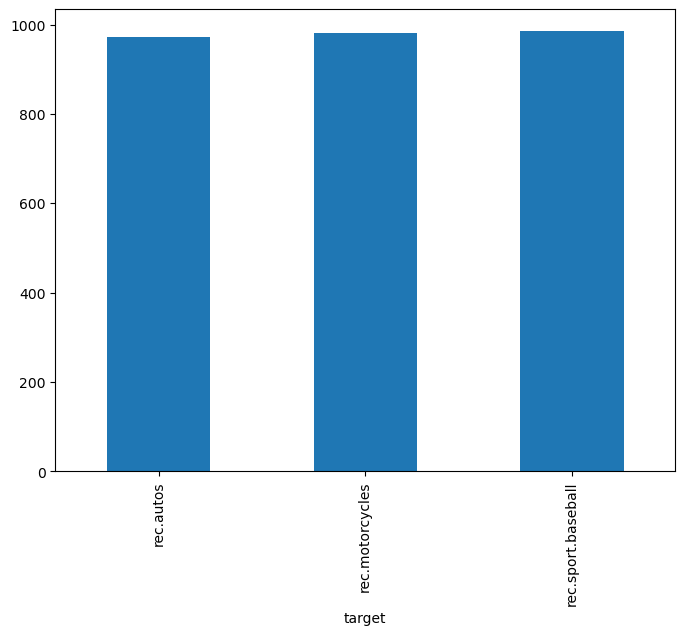

KeyError: 'Difficulty_Level'

In [2]:
# @@@@@@@@@@@@@@@@@@@       DATA PREPROCESSING      @@@@@@@@@@@@@@@@@@@
# @@@@@@@@@@@@@@@@@@@       SPLITTING      @@@@@@@@@@@@@@@@@@@
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.conftest import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import re
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
import sys, os

# # # # https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
# # # if not sys.warnoptions:
# # #     warnings.simplefilter("ignore")
# # #     os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses


categories = ["rec.motorcycles", "rec.autos", "rec.sport.baseball"]

twenty_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42
)

twenty_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42
)


# Extract the "Organization" and "Subject" lines completely from the "text" feature
def extract_information(text):
    lines = text.split("\n")
    organization_line = next(
        (line for line in lines if line.startswith("Organization:")), ""
    )
    subject_line = next((line for line in lines if line.startswith("Subject:")), "")

    organization_removed_text = text.replace(organization_line, "")
    subject_removed_text = organization_removed_text.replace(subject_line, "")

    organization = organization_line.replace("Organization:", "").strip()
    subject = subject_line.replace("Subject:", "").strip()

    return organization, subject, subject_removed_text


# Extract information from the "text" feature for the training and test datasets
organization_train = []
subject_train = []
text_without_information_train = []
for text in twenty_train.data:
    organization, subject, text_without_information = extract_information(text)
    organization_train.append(organization)
    subject_train.append(subject)
    text_without_information_train.append(text_without_information)

organization_test = []
subject_test = []
text_without_information_test = []
for text in twenty_test.data:
    organization, subject, text_without_information = extract_information(text)
    organization_test.append(organization)
    subject_test.append(subject)
    text_without_information_test.append(text_without_information)

# Map target labels to target names
target_names = twenty_train.target_names

target_labels_train = twenty_train.target
target_text_train = [target_names[label] for label in target_labels_train]

target_labels_test = twenty_test.target
target_text_test = [target_names[label] for label in target_labels_test]

# Create a DataFrame for the combined dataset
df_combined = pd.DataFrame(
    {
        "target": target_text_train + target_text_test,
        "text": text_without_information_train + text_without_information_test,
        "organization": organization_train + organization_test,
        "subject": subject_train + subject_test,
    }
)


def showDatasetCharacteristics(df_combined, tittle):
    print(tittle, " \n")

    print(
        "Dataset columns: \n",
        "\t",
        df_combined.columns,
        "\n",
    )
    # Display the initial dimensions of the dataset
    print(
        "Dataset dimensions (rows, columns) : \n",
        "\t",
        df_combined.shape,
        "\n",
    )

    # Retrieve the unique classes in the "Difficulty_Level" column
    unique_classes = df_combined["target"].unique()
    print(
        "Unique classes: \n",
        "\t",
        unique_classes,
        "\n",
    )


showDatasetCharacteristics(df_combined, "-----> Before text cleaning")


def removeRowsWithMissingValues(df_combined):
    collumns = [
        "target",
        "text",
        "organization",
        "subject",
    ]
    df_combined_cleaned = df_combined
    for column in collumns:
        # Remove rows with missing values in the "Difficulty_Level" column
        df_combined = df_combined[pd.notnull(df_combined[column])]

        # Remove rows with missing values in the "Skills" column
        df_combined = df_combined[pd.notnull(df_combined[column])]

        # Remove rows with boolean values in the "Skills" column
        df_combined = df_combined[df_combined[column].astype(bool)]
        df_combined_cleaned = df_combined

    return df_combined_cleaned


# Remove rows with missing values
df_combined = removeRowsWithMissingValues(df_combined)


# Remove punctuation and special characters
def remove_special_characters(text):
    # @@@@@@@@@@@@@@@@@@@@@@@@@ First version disabled because tfdifVectorizer with strip_accents="unicode" fix most of the problems found. @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # Use regular expressions to remove punctuation and special characters EXCEPT by the + character used in c++ Skills column.
    # EXCEPT the - character as used in "2-hour long project-based"
    # clean_text = re.sub(r"[^\w\s+-]", "", text)

    # Use regular expressions to remove special character
    # new version, to just take off the " character, as the Course_Descriptions and some Universities have their text surrounded by "".
    clean_text = re.sub(r'"', "", text)
    return clean_text


# Remove special character "
df_combined["target"] = df_combined["target"].apply(remove_special_characters)
df_combined["text"] = df_combined["text"].apply(remove_special_characters)
df_combined["organization"] = df_combined["organization"].apply(
    remove_special_characters
)
df_combined["subject"] = df_combined["subject"].apply(remove_special_characters)


def remove_numeric_columns(data):
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data = data.drop(columns=numeric_columns, axis=1)
    return data


# Remove columns with just numbers as values
df_combined = remove_numeric_columns(df_combined)


# Create a new column "category_id" and assign unique numeric values based on the "Difficulty_Level" column
df_combined["category_id"] = df_combined["target"].factorize()[0]

# Remove rows with missing values
df_combined = removeRowsWithMissingValues(df_combined)


showDatasetCharacteristics(df_combined, "-----> After text cleaning")


def plotClassBalanceGraph(df_combined):
    # Display the head of the cleaned dataset
    # print(df_combined.head())
    print("CLASS BALANCING")
    # Plot a bar chart showing the count of skills per difficulty level
    fig = plt.figure(figsize=(8, 6))
    df_combined.groupby("target").text.count().plot.bar(ylim=0)
    plt.show()


plotClassBalanceGraph(df_combined)


def calculateClassBalanceStatistics(df_combined):
    # Count the number of occurrences for each class
    class_counts = df_combined["Difficulty_Level"].value_counts()

    # Calculate the percentage of each class
    class_percentages = class_counts / class_counts.sum() * 100

    # Create a summary DataFrame with class counts and percentages
    class_imbalance = pd.DataFrame(
        {
            "Class": class_counts.index,
            "Count": class_counts,
            "Percentage": class_percentages,
        }
    )

    # Sort the DataFrame by class count in descending order
    class_imbalance = class_imbalance.sort_values("Count", ascending=False)

    # Print the class imbalance summary
    print("Class Imbalance Summary:")
    print(class_imbalance)


calculateClassBalanceStatistics(df_combined)


# Split the combined dataset into train and test sets
train, test = train_test_split(
    df_combined, test_size=0.40, random_state=42, stratify=df_combined["target"]
)

# Determine the paths to save the train and test files
train_path = Path("./", "train_SCIKIT_DATA.csv")
test_path = Path("./", "test_SCIKIT_DATA.csv")

# Save the train and test files
train.to_csv(train_path, sep=";", index=False)
test.to_csv(test_path, sep=";", index=False)

-----> Before text cleaning  

Dataset columns: 
 	 Index(['target', 'text', 'organization', 'subject'], dtype='object') 

Dataset dimensions (rows, columns) : 
 	 (2980, 4) 

Unique classes: 
 	 ['rec.motorcycles' 'rec.autos' 'rec.sport.baseball'] 

-----> After text cleaning  

Dataset columns: 
 	 Index(['target', 'text', 'organization', 'subject', 'category_id'], dtype='object') 

Dataset dimensions (rows, columns) : 
 	 (2938, 5) 

Unique classes: 
 	 ['rec.motorcycles' 'rec.autos' 'rec.sport.baseball'] 

CLASS BALANCING


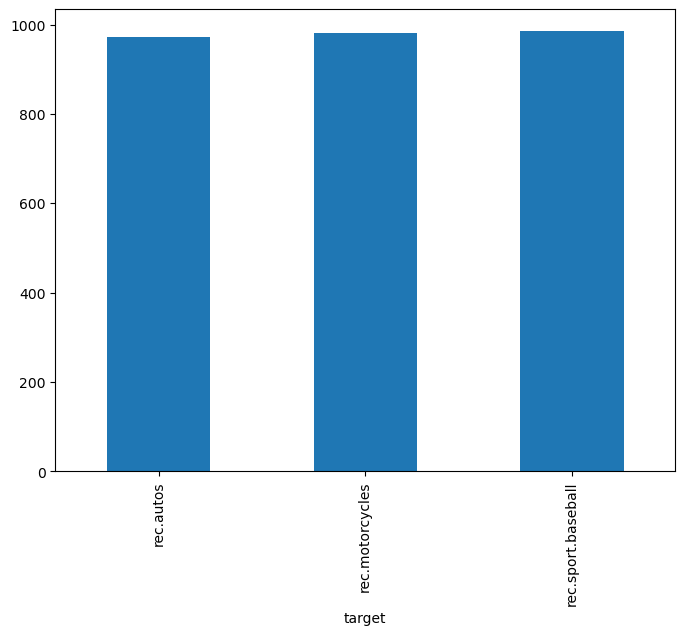

Class Imbalance Summary:
                                 Class  Count  Percentage
rec.sport.baseball  rec.sport.baseball    985   33.526208
rec.motorcycles        rec.motorcycles    981   33.390061
rec.autos                    rec.autos    972   33.083730


In [3]:
# @@@@@@@@@@@@@@@@@@@       DATA PREPROCESSING      @@@@@@@@@@@@@@@@@@@
# @@@@@@@@@@@@@@@@@@@       SPLITTING      @@@@@@@@@@@@@@@@@@@
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.conftest import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import re
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
import sys, os

# # # # https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
# # # if not sys.warnoptions:
# # #     warnings.simplefilter("ignore")
# # #     os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses


categories = ["rec.motorcycles", "rec.autos", "rec.sport.baseball"]

twenty_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42
)

twenty_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42
)


# Extract the "Organization" and "Subject" lines completely from the "text" feature
def extract_information(text):
    lines = text.split("\n")
    organization_line = next(
        (line for line in lines if line.startswith("Organization:")), ""
    )
    subject_line = next((line for line in lines if line.startswith("Subject:")), "")

    organization_removed_text = text.replace(organization_line, "")
    subject_removed_text = organization_removed_text.replace(subject_line, "")

    organization = organization_line.replace("Organization:", "").strip()
    subject = subject_line.replace("Subject:", "").strip()

    return organization, subject, subject_removed_text


# Extract information from the "text" feature for the training and test datasets
organization_train = []
subject_train = []
text_without_information_train = []
for text in twenty_train.data:
    organization, subject, text_without_information = extract_information(text)
    organization_train.append(organization)
    subject_train.append(subject)
    text_without_information_train.append(text_without_information)

organization_test = []
subject_test = []
text_without_information_test = []
for text in twenty_test.data:
    organization, subject, text_without_information = extract_information(text)
    organization_test.append(organization)
    subject_test.append(subject)
    text_without_information_test.append(text_without_information)

# Map target labels to target names
target_names = twenty_train.target_names

target_labels_train = twenty_train.target
target_text_train = [target_names[label] for label in target_labels_train]

target_labels_test = twenty_test.target
target_text_test = [target_names[label] for label in target_labels_test]

# Create a DataFrame for the combined dataset
df_combined = pd.DataFrame(
    {
        "target": target_text_train + target_text_test,
        "text": text_without_information_train + text_without_information_test,
        "organization": organization_train + organization_test,
        "subject": subject_train + subject_test,
    }
)


def showDatasetCharacteristics(df_combined, tittle):
    print(tittle, " \n")

    print(
        "Dataset columns: \n",
        "\t",
        df_combined.columns,
        "\n",
    )
    # Display the initial dimensions of the dataset
    print(
        "Dataset dimensions (rows, columns) : \n",
        "\t",
        df_combined.shape,
        "\n",
    )

    # Retrieve the unique classes in the "Difficulty_Level" column
    unique_classes = df_combined["target"].unique()
    print(
        "Unique classes: \n",
        "\t",
        unique_classes,
        "\n",
    )


showDatasetCharacteristics(df_combined, "-----> Before text cleaning")


def removeRowsWithMissingValues(df_combined):
    collumns = [
        "target",
        "text",
        "organization",
        "subject",
    ]
    df_combined_cleaned = df_combined
    for column in collumns:
        # Remove rows with missing values in the "Difficulty_Level" column
        df_combined = df_combined[pd.notnull(df_combined[column])]

        # Remove rows with missing values in the "Skills" column
        df_combined = df_combined[pd.notnull(df_combined[column])]

        # Remove rows with boolean values in the "Skills" column
        df_combined = df_combined[df_combined[column].astype(bool)]
        df_combined_cleaned = df_combined

    return df_combined_cleaned


# Remove rows with missing values
df_combined = removeRowsWithMissingValues(df_combined)


# Remove punctuation and special characters
def remove_special_characters(text):
    # @@@@@@@@@@@@@@@@@@@@@@@@@ First version disabled because tfdifVectorizer with strip_accents="unicode" fix most of the problems found. @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # Use regular expressions to remove punctuation and special characters EXCEPT by the + character used in c++ Skills column.
    # EXCEPT the - character as used in "2-hour long project-based"
    # clean_text = re.sub(r"[^\w\s+-]", "", text)

    # Use regular expressions to remove special character
    # new version, to just take off the " character, as the Course_Descriptions and some Universities have their text surrounded by "".
    clean_text = re.sub(r'"', "", text)
    return clean_text


# Remove special character "
df_combined["target"] = df_combined["target"].apply(remove_special_characters)
df_combined["text"] = df_combined["text"].apply(remove_special_characters)
df_combined["organization"] = df_combined["organization"].apply(
    remove_special_characters
)
df_combined["subject"] = df_combined["subject"].apply(remove_special_characters)


def remove_numeric_columns(data):
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data = data.drop(columns=numeric_columns, axis=1)
    return data


# Remove columns with just numbers as values
df_combined = remove_numeric_columns(df_combined)


# Create a new column "category_id" and assign unique numeric values based on the "Difficulty_Level" column
df_combined["category_id"] = df_combined["target"].factorize()[0]

# Remove rows with missing values
df_combined = removeRowsWithMissingValues(df_combined)


showDatasetCharacteristics(df_combined, "-----> After text cleaning")


def plotClassBalanceGraph(df_combined):
    # Display the head of the cleaned dataset
    # print(df_combined.head())
    print("CLASS BALANCING")
    # Plot a bar chart showing the count of skills per difficulty level
    fig = plt.figure(figsize=(8, 6))
    df_combined.groupby("target").text.count().plot.bar(ylim=0)
    plt.show()


plotClassBalanceGraph(df_combined)


def calculateClassBalanceStatistics(df_combined):
    # Count the number of occurrences for each class
    class_counts = df_combined["target"].value_counts()

    # Calculate the percentage of each class
    class_percentages = class_counts / class_counts.sum() * 100

    # Create a summary DataFrame with class counts and percentages
    class_imbalance = pd.DataFrame(
        {
            "Class": class_counts.index,
            "Count": class_counts,
            "Percentage": class_percentages,
        }
    )

    # Sort the DataFrame by class count in descending order
    class_imbalance = class_imbalance.sort_values("Count", ascending=False)

    # Print the class imbalance summary
    print("Class Imbalance Summary:")
    print(class_imbalance)


calculateClassBalanceStatistics(df_combined)


# Split the combined dataset into train and test sets
train, test = train_test_split(
    df_combined, test_size=0.40, random_state=42, stratify=df_combined["target"]
)

# Determine the paths to save the train and test files
train_path = Path("./", "train_SCIKIT_DATA.csv")
test_path = Path("./", "test_SCIKIT_DATA.csv")

# Save the train and test files
train.to_csv(train_path, sep=";", index=False)
test.to_csv(test_path, sep=";", index=False)